In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

from datatools import extract_market_data, data_quantization
from pipeline import Dataset
from pipeline.backtest import evaluation_for_submission, cross_validation
from visualization.metric import plot_performance

import xarray as xr

sns.set_style('whitegrid')

In [3]:
base_ds = xr.open_dataset('../../data/nc/base.nc')
market_brief_ds = xr.open_dataset('../../data/nc/market_brief.nc')
ds = base_ds.merge(market_brief_ds)

In [4]:
ds

<xarray.Dataset>
Dimensions:            (day: 1000, asset: 54, timeslot: 50)
Coordinates:
  * day                (day) int32 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000
  * asset              (asset) int32 0 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52 53
  * timeslot           (timeslot) int32 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
Data variables: (12/22)
    open               (day, asset, timeslot) float64 ...
    close              (day, asset, timeslot) float64 ...
    high               (day, asset, timeslot) float64 ...
    low                (day, asset, timeslot) float64 ...
    volume             (day, asset, timeslot) float64 ...
    money              (day, asset, timeslot) float64 ...
    ...                 ...
    mean_volume        (day, asset) float64 ...
    close_0            (day, asset) float64 ...
    open_0             (day, asset) float64 ...
    high_0             (day, asset) float64 ...
    low_0              (day, asset) float64 ...
    return_0           (day, asset) float64 ...

## Getting the market value

In [5]:
ds['earnings_ttm'] = ds['close_0'] / ds['pe_ttm']
ds['earnings'] = ds['close_0'] / ds['pe']
ds['book'] = ds['close_0'] / ds['pb']
ds['sales'] = ds['close_0'] / ds['ps']
ds['cashflow'] = ds['close_0'] / ds['pcf']

In [6]:
ds['market_share_history'] = ds['volume'].sum('timeslot') / ds['turnoverRatio']
ds['market_share'] = ds['market_share_history'].sel(day=slice(990, 1000)).median(dim='day')
ds['market_cap'] = ds['market_share'] * ds['close_0']

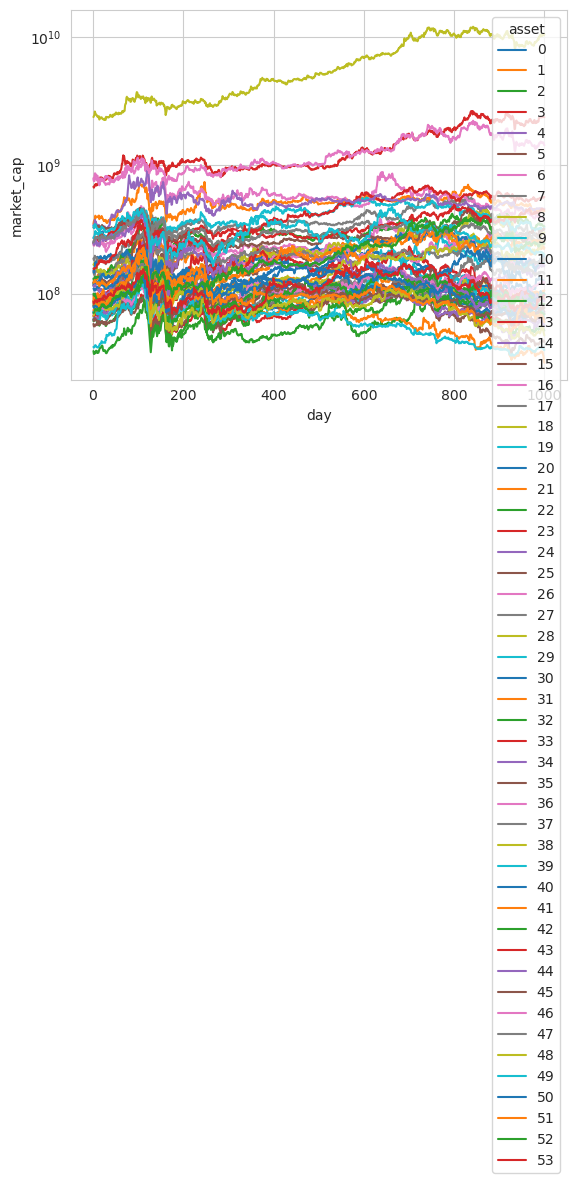

In [7]:
ds['market_cap'].plot.line(x='day')
plt.yscale('log')

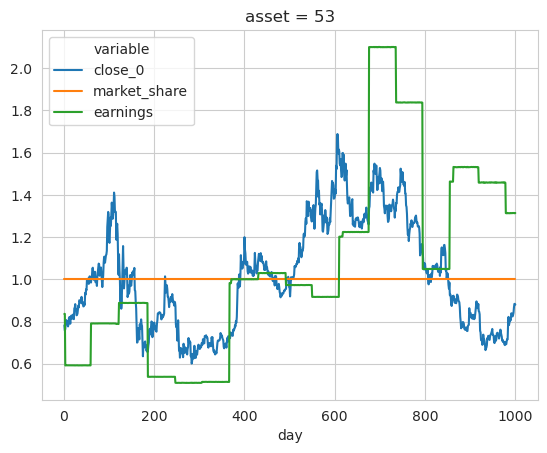

In [8]:
def fair_plot(ds):
    sub_ds = ds / ds.median(dim='day')
    sub_ds.to_array().plot.line(x='day')

fair_plot(ds[[
    'close_0',
    'market_share',
#   'mean_volume',
#   'turnoverRatio',
    'earnings',
]
#            ].sel(asset=1, day=slice(150, 250)))
#            ].sel(asset=7, day=slice(500, 700)))
#            ].sel(asset=13, day=slice(400, 600)))
#            ].sel(asset=31, day=slice(100, 200)))
#            ].sel(asset=50, day=slice(720, 1000)))
            ].sel(asset=53, day=slice(1, 1000)))

**Conclusion:**

We think split has been accounted in almost every column except turnoveRatio

## Does value model work?

In [9]:
df = ds[['market_cap', 'book', 'earnings', 'earnings_ttm', 'sales', 'cashflow', 'return']].to_dataframe()

In [10]:
df['cap_2_book'] = df['market_cap'] / df['book'] / 1e8
df['earnings_2_book'] = df['earnings'] / df['book']
df['earnings_ttm_2_book'] = df['earnings_ttm'] / df['book']
df['sales_2_book'] = df['sales'] / df['book']
df['cashflow_2_book'] = df['cashflow'] / df['book']

selection = ['cap_2_book', 'earnings_2_book', 'earnings_ttm_2_book', 'sales_2_book', 'cashflow_2_book', 'return']
df_full = df[selection].swaplevel().sort_index()

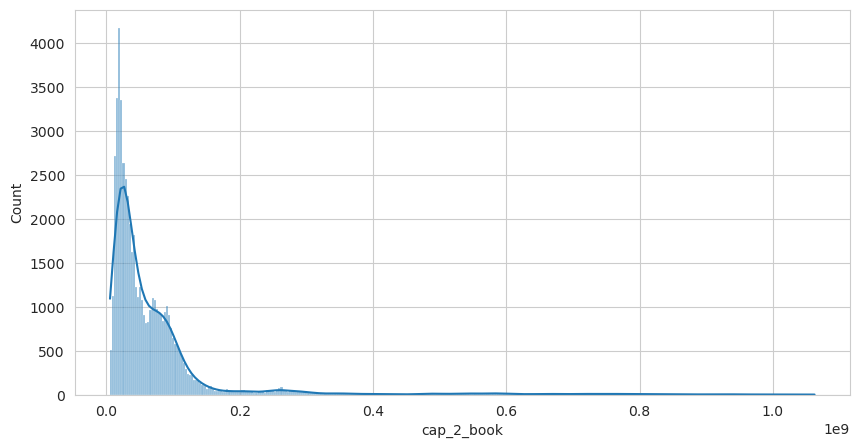

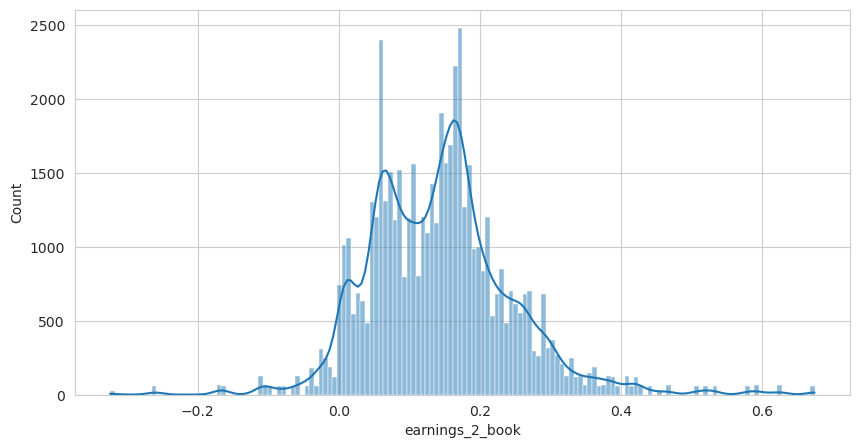

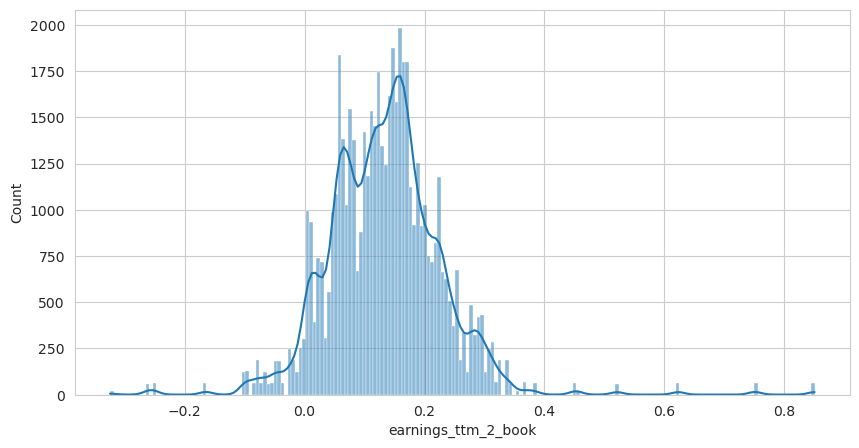

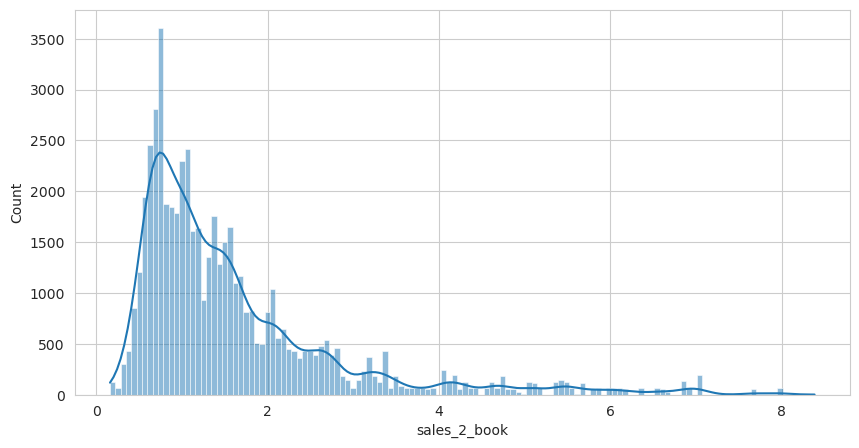

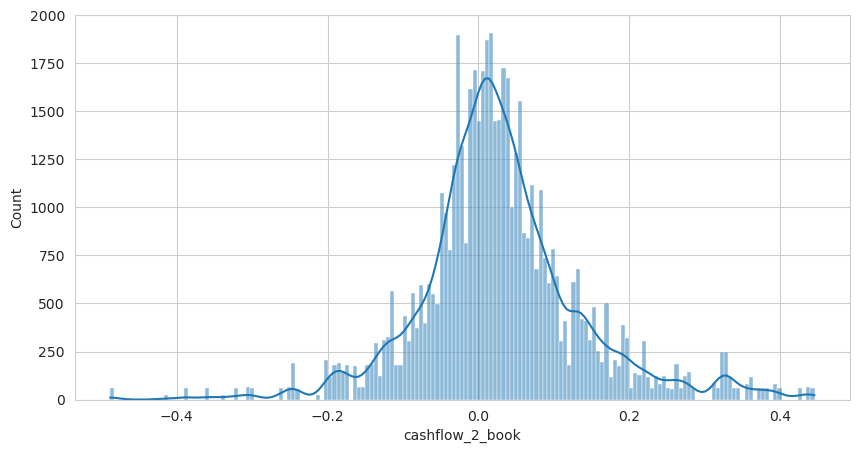

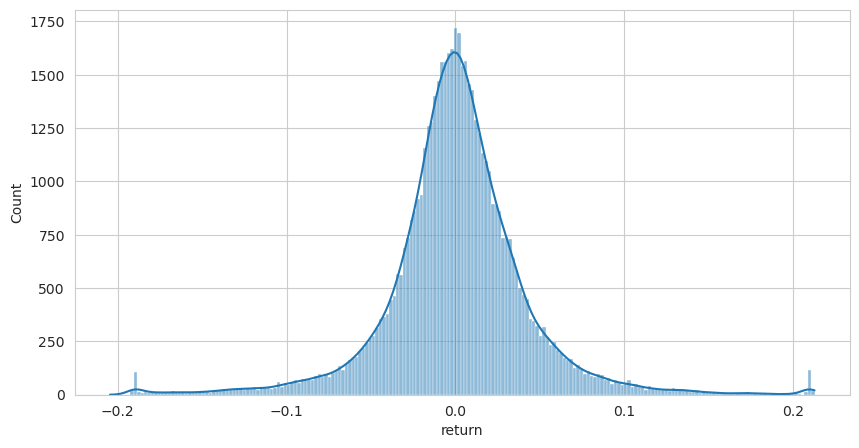

In [145]:
for col in df_full.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[col], kde=True)

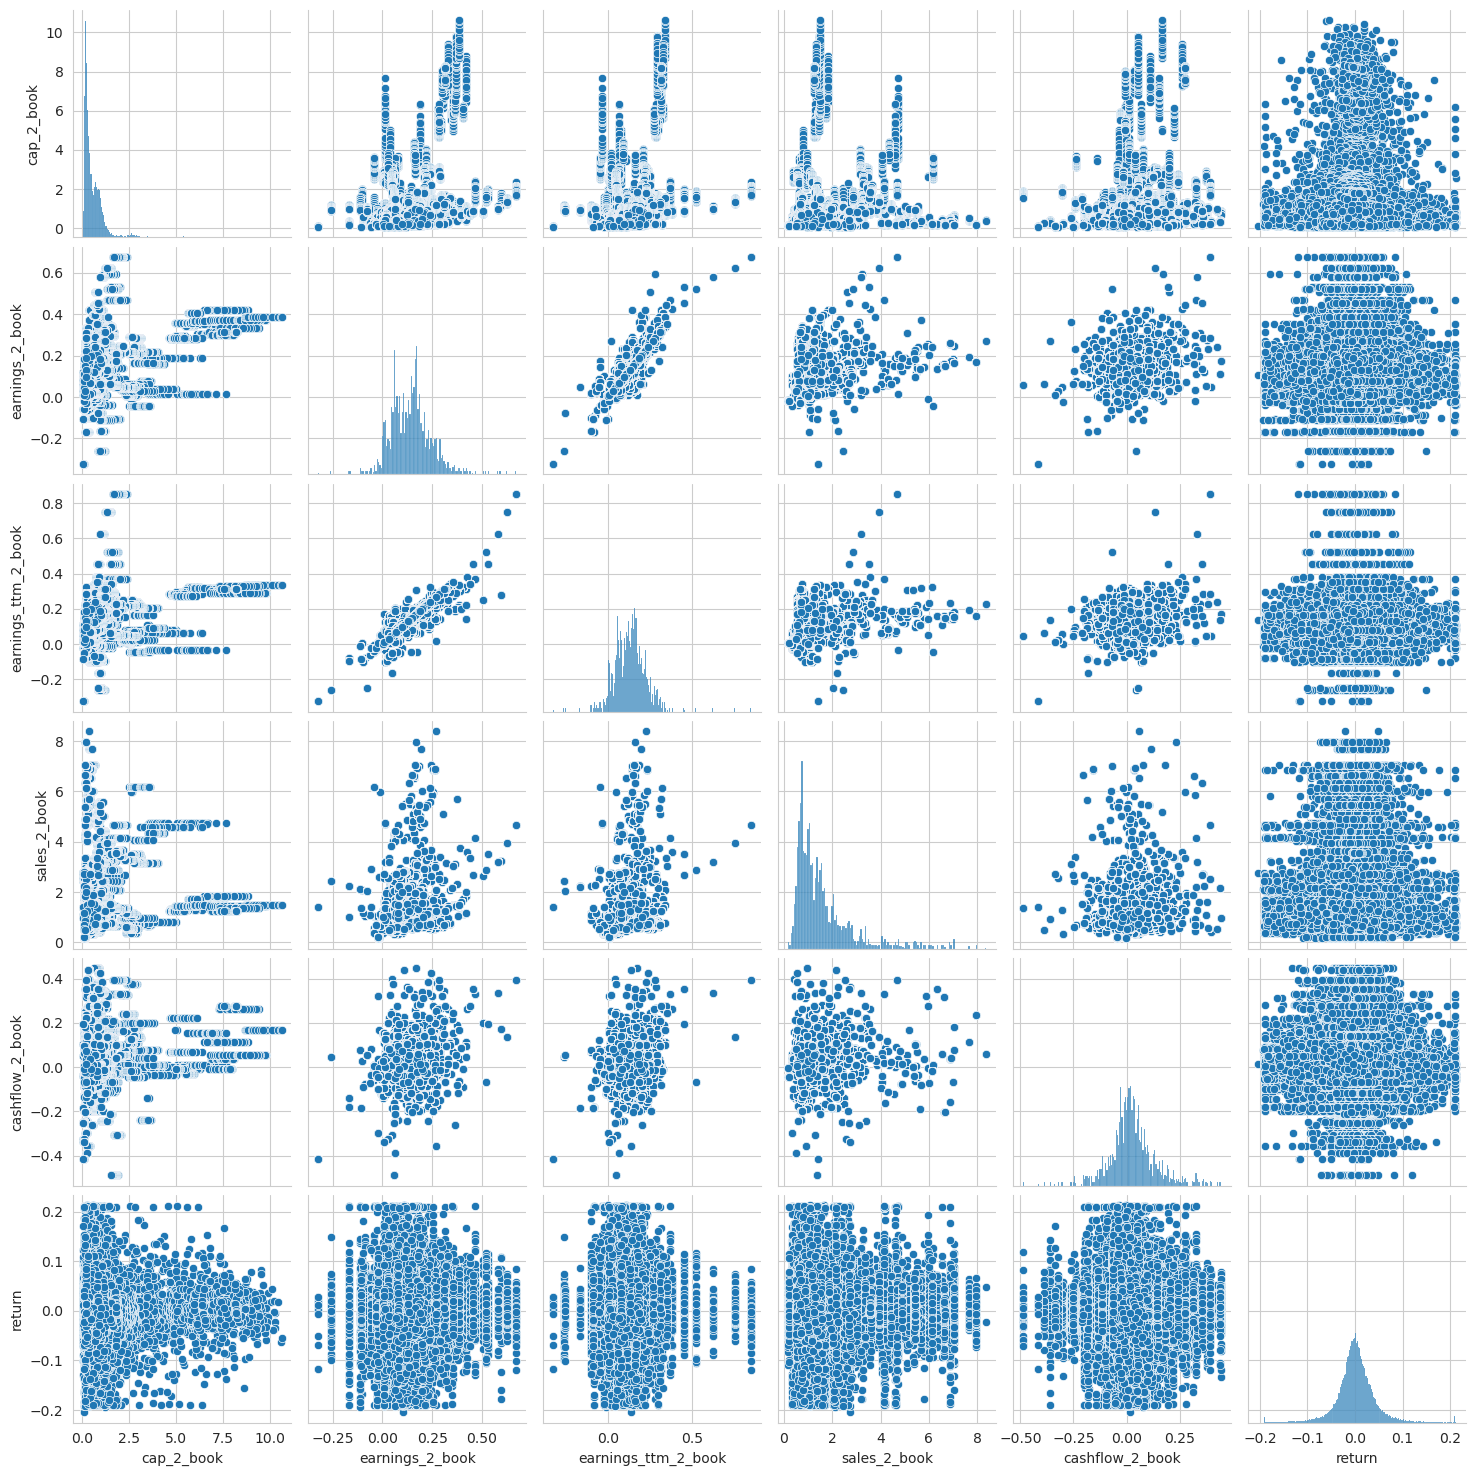

In [147]:
sns.pairplot(df_full)

In [97]:
df_0 = ds[['market_cap', 'book', 'earnings', 'earnings_ttm', 'sales', 'cashflow', 'return']].sel(asset=0).to_dataframe()

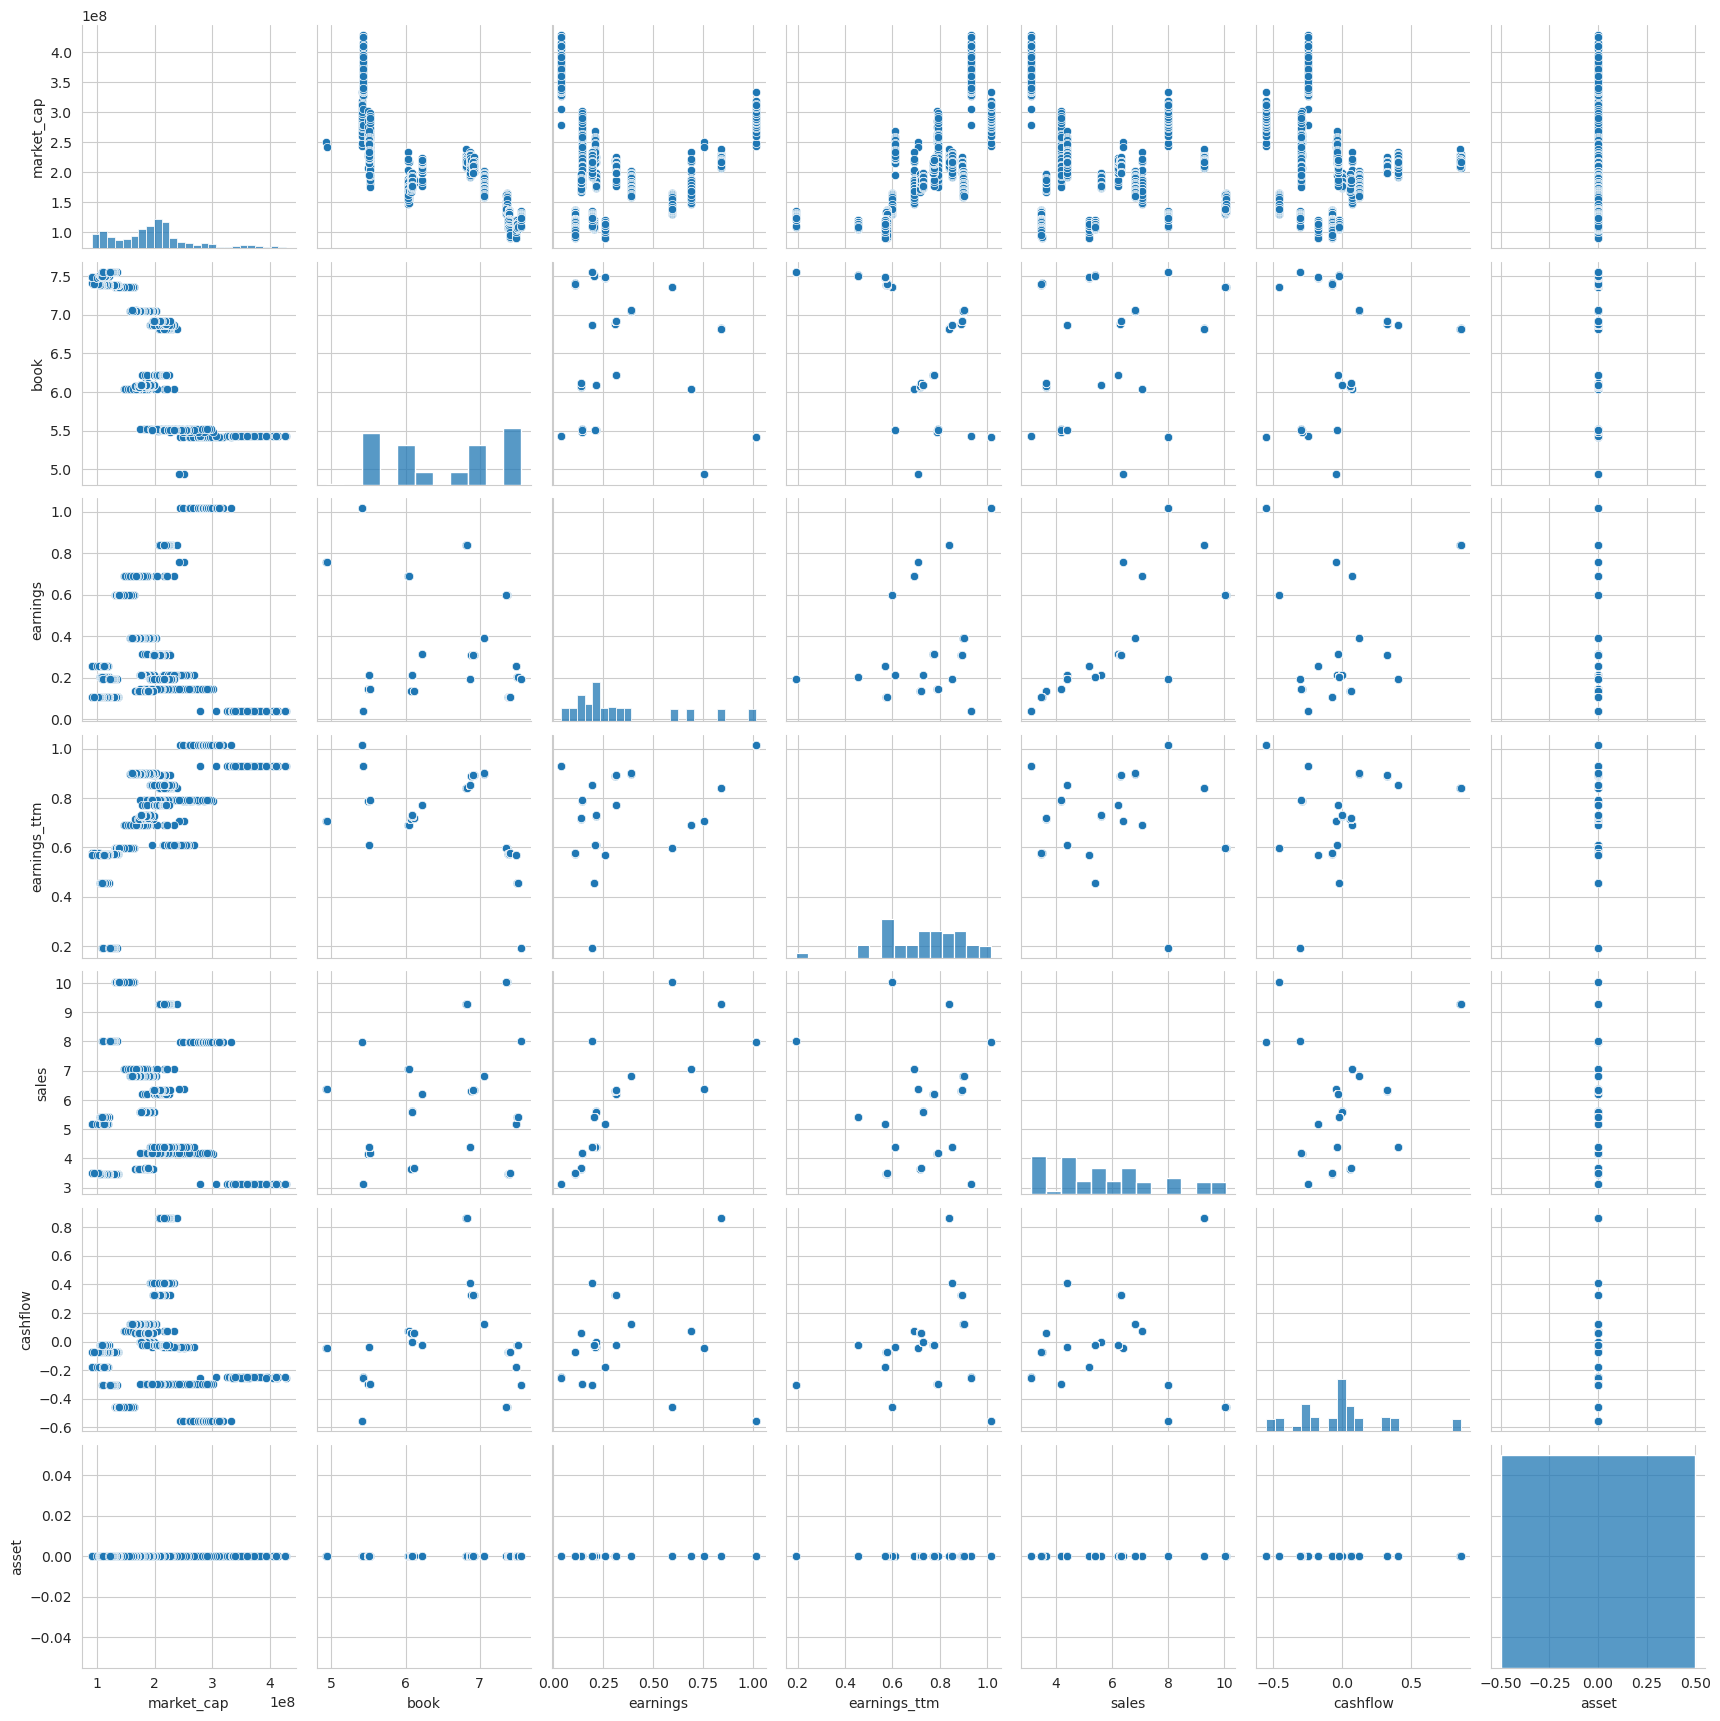

In [94]:
sns.pairplot(df_0)

In [68]:
class kernel_conditional_estimator:
    def __init__(self, X_train, y_train, kernel):
        self.X_train = X_train
        self.y_train = y_train
        self.kernel = kernel
    
    def estimate(self, X_val):
        X_train_np = self.X_train.values[None, :, :]
        y_train_np = self.y_train.values[None, :]
        X_val_np = X_val.values[:, None, :]
        
        
        weight = self.kernel(X_train_np - X_val_np).prod(axis=2) + 1e-9
        print(weight.shape)
        y_val_np = (y_train_np * weight).sum(axis=1) / (weight).sum(axis=1)
        y_val = Series(data=y_val_np, index=X_val.index)
        return y_val

In [159]:
feature = ['earnings_2_book', 'earnings_ttm_2_book', 'sales_2_book', 'cashflow_2_book']
target = 'cap_2_book'
X = df_full[feature]
y = df_full[target]
reg = LinearRegression().fit(X.iloc[200*54:500*54], y[200*54:500*54])
print(reg.score(X, y))

X_val = X.loc[idx[range(500, 900), :]]
y_val_true = y.loc[X_val.index]
print(reg.score(X_val, y_val_true))

0.09593972159337738
0.12632505661006976


In [110]:
idx = pd.IndexSlice

In [183]:
h = 0.003
kernel = lambda t: np.exp(-(t**2) / (2 * h))
# h = 0.04
# kernel = lambda t: np.exp(-np.abs(t) / h)
X_train = X.loc[idx[range(200, 500, 30), :]]
y_train_true = y.loc[X_train.index]
est = kernel_conditional_estimator(X_train, y_train_true, kernel)

In [184]:
from sklearn.metrics import r2_score

y_train_pred = est.estimate(X_train)
print(r2_score(y_train_true, y_train_pred))
y_val_pred = est.estimate(X_val)
print(r2_score(y_val_true, y_val_pred))

(540, 540)
0.9017761659729332
(21600, 540)
0.5568420529277613


In [185]:
df_full['value_2_book_kernel'] = est.estimate(X)

(54000, 540)


In [120]:
df_full['value_2_book'] = reg.predict(X)

In [103]:
df_full

cap_2_book  earnings_2_book  earnings_ttm_2_book  sales_2_book  \
day  asset                                                                   
1    0        0.507303         0.153005             0.143500      1.294526   
     1        0.386622         0.185358             0.174357      1.658313   
     2        0.697749         0.114680             0.111990      1.161650   
     3        0.159989         0.158688             0.143873      3.273651   
     4        0.589040        -0.007090            -0.008301      1.045761   
...                ...              ...                  ...           ...   
1000 49       0.408114         0.068866             0.068866      2.698732   
     50       0.219066         0.128807             0.128807      2.163728   
     51       0.227487         0.096829             0.096829      2.015961   
     52       0.489910         0.199553             0.199553      1.557348   
     53       0.194405         0.187363             0.187363      4.899975   

            cashflow_2_book    return  value_2_book_kernel  value_2_book  
day  asset                                                                
1    0            -0.008540 -0.026877             0.280347      0.742089  
     1             0.212172 -0.052674             0.320369      0.822912  
     2            -0.082591 -0.002691             0.277932      0.637268  
     3             0.035879 -0.018515             0.320369      0.871629  
     4            -0.121746 -0.019184             0.329399      0.270955  
...                     ...       ...                  ...           ...  
1000 49            0.038686       NaN             0.320369      0.577628  
     50           -0.065831       NaN             0.320369      0.742717  
     51            0.072383       NaN             0.320369      0.612964  
     52           -0.009933       NaN             0.320369      0.908019  
     53            0.014832       NaN             0.320369      1.078084  

[54000 rows x 8 columns]

<Axes: xlabel='value_2_book', ylabel='cap_2_book'>

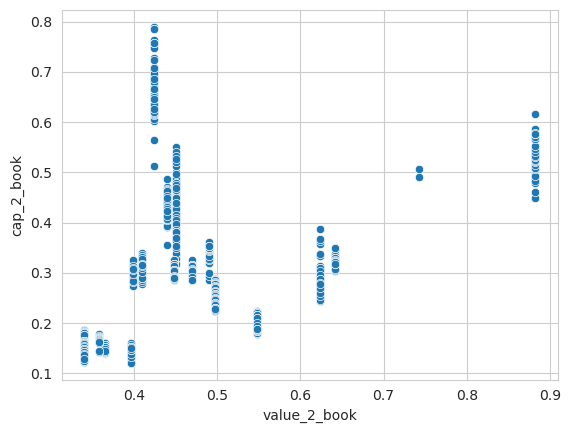

In [42]:
sns.scatterplot(data=df_full.iloc[0::54], x='value_2_book', y='cap_2_book')

<Axes: xlabel='value_2_book_kernel', ylabel='cap_2_book'>

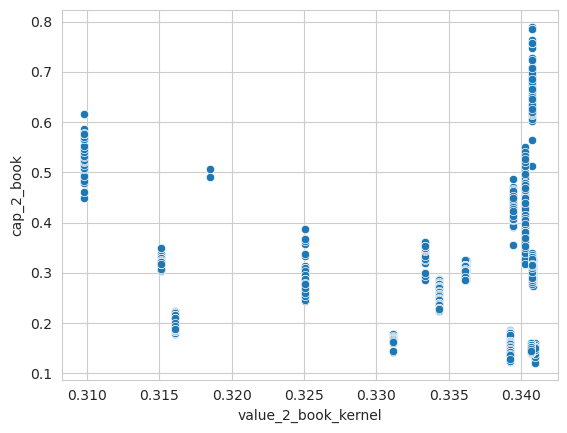

In [43]:
sns.scatterplot(data=df_full.iloc[0::54], x='value_2_book_kernel', y='cap_2_book')

<Axes: xlabel='day,asset'>

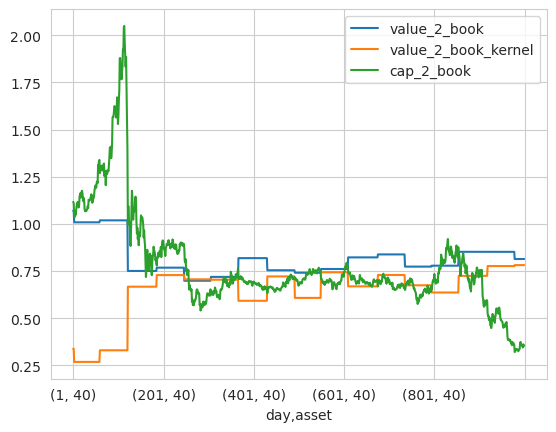

In [186]:
df_full.iloc[40::54][['value_2_book', 'value_2_book_kernel', 'cap_2_book']].plot.line()

In [187]:
df_full['outlook_kernel'] = df_full['value_2_book_kernel'] / df_full['cap_2_book']
df_full['outlook'] = df_full['value_2_book'] / df_full['cap_2_book']

<Axes: xlabel='outlook', ylabel='return'>

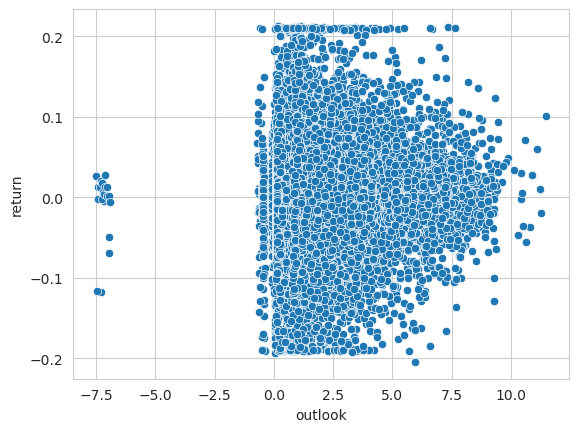

In [188]:
sns.scatterplot(data=df_full, x='outlook', y='return')

In [189]:
df_full['outlook'].corr(df_full['return'])

0.015096857723434878

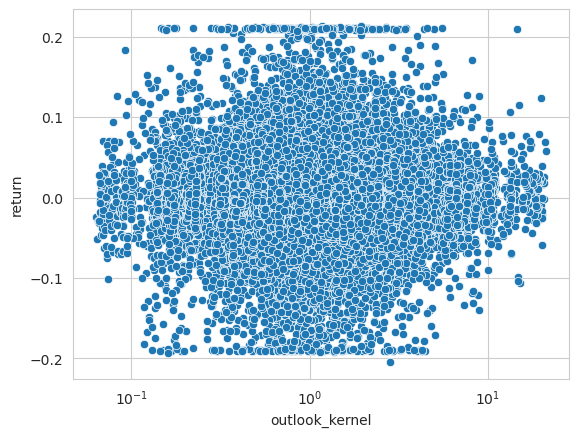

In [191]:
sns.scatterplot(data=df_full, x='outlook_kernel', y='return')
plt.xscale('log')

In [193]:
np.log(df_full['outlook_kernel']).corr(df_full['return'])

0.012551704641140913

kernel learning example

In [72]:
vdf = DataFrame({
    'f1': np.random.randn(100),
    'f2': np.random.randn(100),
    'f3': np.random.randn(100),
    'f4': np.random.randn(100),
})
vdf['t'] = (vdf['f1'] ** 2 + vdf['f2'] - vdf['f3'] * 3) * vdf['f4']

In [73]:
vX_train = vdf.iloc[:50][['f1', 'f2', 'f3', 'f4']]
vX_val = vdf.iloc[50:][['f1', 'f2', 'f3', 'f4']]
vy_train = vdf.iloc[:50]['t']
vy_val = vdf.iloc[50:]['t']

In [74]:
vreg = LinearRegression().fit(vX_train, vy_train)
vy_train_pred = vreg.predict(vX_train)
print(r2_score(vy_train, vy_train_pred))
vy_val_pred = vreg.predict(vX_val)
print(r2_score(vy_val, vy_val_pred))

0.3541139009902008
-0.34675801401923523


In [92]:
# h = 0.2
# kernel = lambda t: np.exp(-(t**2) / (2 * h))
h = 0.15
kernel = lambda t: np.exp(-np.abs(t) / (2 * h))
vest = kernel_conditional_estimator(vX_train, vy_train, kernel)
vy_train_pred = vest.estimate(vX_train)
print(r2_score(vy_train, vy_train_pred))
vy_val_pred = vest.estimate(vX_val)
print(r2_score(vy_val, vy_val_pred))

(50, 50)
0.9999499170394761
(50, 50)
0.5758530390133011


## Let us test the performance!

In [203]:
ds['earnings_2_book'] = ds['earnings'] / ds['book']
ds['earnings_ttm_2_book'] = ds['earnings_ttm'] / ds['book']
ds['sales_2_book'] = ds['sales'] / ds['book']
ds['cashflow_2_book'] = ds['cashflow'] / ds['book']
ds['market_cap_2_book'] = ds['market_cap'] / ds['book'] / 1e8

In [204]:
ds.data_vars

Data variables:
    open                  (day, asset, timeslot) float64 ...
    close                 (day, asset, timeslot) float64 ...
    high                  (day, asset, timeslot) float64 ...
    low                   (day, asset, timeslot) float64 ...
    volume                (day, asset, timeslot) float64 6.422e+05 ... 1.395e+05
    money                 (day, asset, timeslot) float64 ...
    turnoverRatio         (day, asset) float64 ...
    transactionAmount     (day, asset) float64 ...
    pe_ttm                (day, asset) float64 ...
    pe                    (day, asset) float64 ...
    pb                    (day, asset) float64 ...
    ps                    (day, asset) float64 ...
    pcf                   (day, asset) float64 ...
    return                (day, asset) float64 -0.02688 -0.05267 ... nan nan
    avg_price             (day, asset) float64 ...
    volatility            (day, asset) float64 ...
    mean_volume           (day, asset) float64 ...
    close_0

In [208]:
class SimpleLinearRegression:
    def __init__(self, features):
        self.reg = LinearRegression()
        self.features = features
    
    def fit_predict(self, X, y):
        X_pd = X[self.features].to_dataframe()
        y_pd = y.to_series()
        self.reg.fit(X_pd.values, y_pd.values)
        y_pred_pd = Series(data=self.reg.predict(X_pd.values), index=X_pd.index)
        return xr.DataArray.from_series(y_pred_pd)
    
    def predict(self, X):
        X_pd = X[self.features].to_dataframe()
        y_pred_pd = Series(data=self.reg.predict(X_pd.values), index=X_pd.index)
        return xr.DataArray.from_series(y_pred_pd)

In [ ]:
features = ['earnings_2_book', 'earnings_ttm_2_book', 'sales_2_book', 'cashflow_2_book']
target = 'market_cap_2_book'

model = SimpleLinearRegression(features)
performance, cum_y_df = cross_validation(model, features, ds, return_column=target, train_lookback=400)
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

  0%|          | 0/599 [00:00<?, ?it/s]